## Training a model

How will we judge the success of the cancellation classifier? Let's look at a number of measures:  
-The confusion matrix  
  True Negative  |  False Positive  
  False Negative |  True Positive  
-Precision, #True positive/(#True positive + #False positive).  
-Recall, #True positive/(#True positive + #False negative).  
-F score, 2PR/(P+R).  
-Accuracy score, percentage of our guesses correct.

We can also assign a cost saved, using the previous numbers of +\$8000 for a true positive, -\$825 for a false positive.  
(This will give us the cost saved compared to the case if all flights were run).

In [1]:
def cost_saved(conf_matrix):
    cost = conf_matrix[1][1]*8000 - conf_matrix[0][1]*825
    return(cost)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import gc

import pandas as pd

model_data = pd.read_hdf('../data/processed/model_data.hdf')

print('We have {0} samples and {1} features'.format(model_data.shape[0],model_data.shape[1]-1))

We have 5819079 samples and 124 features


This is too large a data set to train with my laptop's memory, so let's only look at a randomly selected subset (10% ~=600,000 rows) and a different, equally sized subset for cross validation.

In [4]:
shuffled_data = model_data.sample(frac=0.2)
cv_data = shuffled_data.iloc[:int(len(shuffled_data)/2),:]
shuffled_data = shuffled_data.iloc[int(len(shuffled_data)/2):,:]

To begin let's look only at the features generated from the original data.

### Logistic regression

Let's start with the simplest algorithm first: logistic regression with the default L2 penalty, with the data split 9:1 for train:test and feature scaling applied.  
As we have few positives let's add 'balanced' class scaling, which will emphasise the features which contribute most to the positives.

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

alg = LogisticRegression(class_weight='balanced')
#Features from original data
predictors = list(model_data.columns[2:64])+list(model_data.columns[66:81])

#Split the data into 10 subsets
kf = KFold(shuffled_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (shuffled_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = shuffled_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (shuffled_data[predictors].iloc[test,:])
    y_test = shuffled_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(shuffled_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(shuffled_data['Cancelled'].values, predictions)
print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(shuffled_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0       1
0  377685  195181
1    2729    6313
precision = 0.03, recall = 0.70, F1 = 0.06, accuracy = 0.66, saved cost per flight = $-189.93


Our recall is pretty high, so we are identifying most of the actual cancellations.  
However the precision is very low as we are generating a lot of false positives, so with this model out of every ~33 flights not run only one would have actually been cancelled.  
Because of these false positives, this model results in a loss of -$190 per flight.

Now let's try regularising the regression to see if, by reducing the variance, we can get any improvement on cost.

In [6]:
#Try these Cs
gc.collect()
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

predictors = list(model_data.columns[2:64])+list(model_data.columns[66:81])

conf_matrix = {}
coef = {}
precision = []; recall = []; F1 = []; accuracy = []; saved_cost = []
for C in C_list:
    alg = LogisticRegression(class_weight='balanced', C=C)
    
    #Split the data into 10 subsets
    kf = KFold(shuffled_data.shape[0], n_folds = 10, random_state = 1)
    predictions = []

    #Train and predict
    for train, test in kf:
        X_train = (shuffled_data[predictors].iloc[train,:])
        scaler = StandardScaler().fit(X_train)
        y_train = shuffled_data['Cancelled'].iloc[train]
        alg.fit(scaler.transform(X_train), y_train)
        X_test = (shuffled_data[predictors].iloc[test,:])
        y_test = shuffled_data['Cancelled'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)
        gc.collect()

    predictions = np.concatenate(predictions,axis = 0)
    coef[C] = alg.coef_
    conf_matrix[C] = confusion_matrix(shuffled_data['Cancelled'].values, predictions)
    print('C = {0}\nConfusion matrix'.format(C))
    print(pd.DataFrame(conf_matrix[C]))
    
    scores = precision_recall_fscore_support(shuffled_data['Cancelled'].values, predictions)
    precision.append(scores[0][1]); recall.append(scores[1][1]); F1.append(scores[2][1])
    accuracy.append(accuracy_score(shuffled_data['Cancelled'].values, predictions))
    saved_cost.append(cost_saved(conf_matrix[C])/len(predictions))
    
    print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(precision[-1],recall[-1],F1[-1],
                                                                   accuracy[-1],saved_cost[-1]))
    

C = 1e-07
Confusion matrix
        0       1
0  298323  274543
1    2048    6994
precision = 0.02, recall = 0.77, F1 = 0.05, accuracy = 0.52, saved cost per flight = $-293.08
C = 1e-06
Confusion matrix
        0       1
0  307448  265418
1    2098    6944
precision = 0.03, recall = 0.77, F1 = 0.05, accuracy = 0.54, saved cost per flight = $-280.83
C = 1e-05
Confusion matrix
        0       1
0  341915  230951
1    2391    6651
precision = 0.03, recall = 0.74, F1 = 0.05, accuracy = 0.60, saved cost per flight = $-235.99
C = 0.0001
Confusion matrix
        0       1
0  370614  202252
1    2621    6421
precision = 0.03, recall = 0.71, F1 = 0.06, accuracy = 0.65, saved cost per flight = $-198.47
C = 0.001
Confusion matrix
        0       1
0  376798  196068
1    2713    6329
precision = 0.03, recall = 0.70, F1 = 0.06, accuracy = 0.66, saved cost per flight = $-190.97
C = 0.01
Confusion matrix
        0       1
0  377606  195260
1    2730    6312
precision = 0.03, recall = 0.70, F1 = 0.06, 

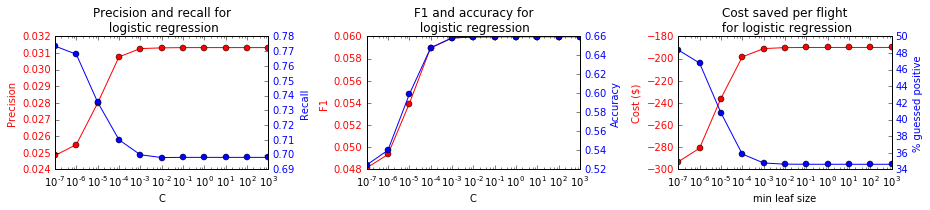

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
y_formatter = ScalarFormatter(useOffset=True)

fig = plt.figure(figsize=(13,3))
ax1 = fig.add_subplot(131)
ax1.plot(C_list,precision,'-or')
ax1.set_xlabel('C')
ax1.set_xscale('log')
ax1.set_ylabel('Precision', color='r')
ax1.set_title('Precision and recall for\n logistic regression')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(C_list, recall, '-ob')
ax2.set_ylabel('Recall', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
ax3 = fig.add_subplot(132)
ax3.plot(C_list,F1,'-or')
ax3.set_xlabel('C')
ax3.set_xscale('log')
ax3.set_ylabel('F1', color='r')
ax3.set_title('F1 and accuracy for\n logistic regression')
for tl in ax3.get_yticklabels():
    tl.set_color('r')

ax4 = ax3.twinx()
ax4.plot(C_list, accuracy, '-ob')
ax4.set_ylabel('Accuracy', color='b')
ax4.yaxis.set_major_formatter(y_formatter)
for tl in ax4.get_yticklabels():
    tl.set_color('b')
    
ax5 = fig.add_subplot(133)
ax5.plot(C_list,saved_cost,'-or')
ax5.set_xlabel('min leaf size')
ax5.set_xscale('log')
ax5.set_ylabel('Cost ($)',color='r')
ax5.set_title('Cost saved per flight\n for logistic regression')
for tl in ax5.get_yticklabels():
    tl.set_color('r')

num_pos = [(conf_matrix[C][0][1]+conf_matrix[C][1][1])*100/sum(sum(conf_matrix[C]))
           for C in C_list]
ax6 = ax5.twinx()
ax6.plot(C_list, num_pos, '-ob')
ax6.set_ylabel('% guessed positive', color='b')
ax6.yaxis.set_major_formatter(y_formatter)
for tl in ax6.get_yticklabels():
    tl.set_color('b')

fig.tight_layout()
fig.savefig('../reports/figures/classification/log_reg_C', bbox_inches='tight')

Increasing the regularisation (decreasing C) helps the recall further by introducing more bias, but at the detriment of the precision, with a balance between the two at C=1e-5.  
Decreasing the regularisation (increasing C) has little effect on either precision or recall, so the best cost is that we first found for C=1.

Let's look at which features were the most important:

In [11]:
for index in np.argsort(abs(coef[1]))[0][:-11:-1]:
    print(predictors[index]+': '+str(coef[1][0][index]))

Days after winter storm: -0.661352820195
DL: -0.372698497111
MQ: 0.252823853387
AS: -0.213855856748
Distance: -0.187959239687
Week in year: 0.186754481363
HA: -0.183430034978
Days from public event: 0.161721224789
Origin NY: 0.148940697566
EV: 0.146426771238


So, as might be expected, knowing when the large storms were is the most important. As New York was one of the worst hit, it is also has a positive trend for cancellations.

Other temporal features are also important: there are more cancellations at the start of the week, and after public events.

Perhaps more surprisingly, flight distance is also high up: longer flights are cancelled less.

For the carriers, Delta Airlines (DL) cancels less while American Eagle (MQ) cancels more. This agrees with what we saw in our explanatory data analysis:

In [26]:
carriers = pd.read_csv('../data/raw/carriersnew.csv')
carriers.dropna(how='any', inplace=True)
carriers.reset_index(inplace=True)
carriers.drop('index', axis=1, inplace=True)
carriers.set_index('Code', inplace=True)
carriers.ix['US','Description'] = 'US Airways Inc.'
carriers = carriers[~carriers['number of flights'].isnull()]
carriers.sort_values(by='number of flights', inplace=True, ascending=False)
carriers['Trend'] = [coef[1][0][np.array(predictors)==index][0] for index in carriers.index]

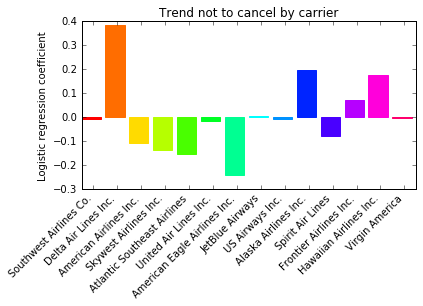

In [28]:
import colorsys

N = len(carriers)
HSV_tuples = [(x*1.0/N, 1, 1) for x in range(N)]
RGB_tuples = [colorsys.hsv_to_rgb(*x) for x in HSV_tuples]
col_dict = {}
for i in range(N):
    col_dict[carriers.index[i]] = RGB_tuples[i]

fig = plt.figure(figsize=(6,3))
#Plot the number of flights
ax1 = fig.add_subplot(111)
bars = ax1.bar(np.arange(0,N), -carriers['Trend'].values)
for i in range(N):
    bars[i].set_color(col_dict[carriers.index[i]])
ax1.set_ylabel('Logistic regression coefficient')
ax1.set_xticks(np.arange(0,N)+0.5)
ax1.set_xticklabels(carriers['Description'].values, rotation=45, ha='right')
ax1.set_title('Trend not to cancel by carrier')

fig.savefig('../reports/figures/classification/log_reg_carrier', bbox_inches='tight')

So the trends for each carrier picked out by logistic regression agree with those we saw in the exploratory data analysis.

Now let's try an algorithm we'd expect to perform rather better.

Now let's look at the performance on the test set.

In [20]:
alg = LogisticRegression(class_weight='balanced', C=1)
#Features from original data
predictors = list(model_data.columns[2:64])+list(model_data.columns[66:81])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0       1
0  382825  190286
1    2683    6114
precision = 0.03, recall = 0.70, F1 = 0.06, accuracy = 0.67, saved cost per flight = $-185.72


### Random forest classification

Let's try a random forest classifier on the data, again doing a 9:1 train:test split on 10% of the total data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

alg = RandomForestClassifier()
predictors = list(model_data.columns[2:64])+list(model_data.columns[66:81])

#Split the data into 10 subsets
kf = KFold(shuffled_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (shuffled_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = shuffled_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (shuffled_data[predictors].iloc[test,:])
    y_test = shuffled_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(shuffled_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(shuffled_data['Cancelled'].values, predictions)
print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(shuffled_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

So for random forest our recall is far smaller but out precision is far higher: we're predicting fewer cancellations, but with much higher accuracy.  
This means we can now making a saving by not running the identified flights.

Now let's try and optimise the classifier.

In [14]:
#Try these leaves
leaf_list = [1,2,3,5,7,10]

predictors = list(model_data.columns[2:64])+list(model_data.columns[66:81])

conf_matrix = {}
coef = {}
precision = []; recall = []; F1 = []; accuracy = []; saved_cost = []
for leaf in leaf_list:
    alg = RandomForestClassifier(min_samples_leaf=leaf)

    #Split the data into 10 subsets
    kf = KFold(shuffled_data.shape[0], n_folds = 10, random_state = 1)
    predictions = []

    #Train and predict
    for train, test in kf:
        X_train = (shuffled_data[predictors].iloc[train,:])
        scaler = StandardScaler().fit(X_train)
        y_train = shuffled_data['Cancelled'].iloc[train]
        alg.fit(scaler.transform(X_train), y_train)
        X_test = (shuffled_data[predictors].iloc[test,:])
        y_test = shuffled_data['Cancelled'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)
        gc.collect()

    predictions = np.concatenate(predictions,axis = 0)
    conf_matrix[leaf] = confusion_matrix(shuffled_data['Cancelled'].values, predictions)
    print('Min leaf size = {0}\nConfusion matrix'.format(leaf))
    print(pd.DataFrame(conf_matrix[leaf]))
    
    scores = precision_recall_fscore_support(shuffled_data['Cancelled'].values, predictions)
    precision.append(scores[0][1]); recall.append(scores[1][1]); F1.append(scores[2][1])
    accuracy.append(accuracy_score(shuffled_data['Cancelled'].values, predictions))
    saved_cost.append(cost_saved(conf_matrix[leaf])/len(predictions))
    
    print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(precision[-1],recall[-1],F1[-1],
                                                                   accuracy[-1],saved_cost[-1]))

Min leaf size = 1
Confusion matrix
        0     1
0  572124   742
1    7800  1242
precision = 0.63, recall = 0.14, F1 = 0.23, accuracy = 0.99, saved cost per flight = $16.02
Min leaf size = 2
Confusion matrix
        0    1
0  572649  217
1    8218  824
precision = 0.79, recall = 0.09, F1 = 0.16, accuracy = 0.99, saved cost per flight = $11.02
Min leaf size = 3
Confusion matrix
        0    1
0  572741  125
1    8471  571
precision = 0.82, recall = 0.06, F1 = 0.12, accuracy = 0.99, saved cost per flight = $7.67
Min leaf size = 5
Confusion matrix
        0    1
0  572797   69
1    8726  316
precision = 0.82, recall = 0.03, F1 = 0.07, accuracy = 0.98, saved cost per flight = $4.25
Min leaf size = 7
Confusion matrix
        0    1
0  572823   43
1    8829  213
precision = 0.83, recall = 0.02, F1 = 0.05, accuracy = 0.98, saved cost per flight = $2.87
Min leaf size = 10
Confusion matrix
        0    1
0  572844   22
1    8925  117
precision = 0.84, recall = 0.01, F1 = 0.03, accuracy = 0.98

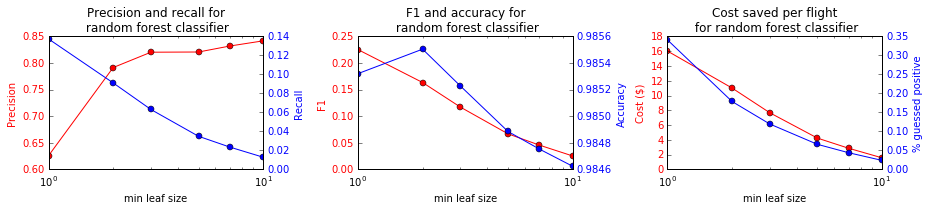

In [16]:
fig = plt.figure(figsize=(13,3))
ax1 = fig.add_subplot(131)
ax1.plot(leaf_list,precision,'-or')
ax1.set_xlabel('min leaf size')
ax1.set_xscale('log')
ax1.set_ylabel('Precision', color='r')
ax1.set_title('Precision and recall for\n random forest classifier')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(leaf_list, recall, '-ob')
ax2.set_ylabel('Recall', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
ax3 = fig.add_subplot(132)
ax3.plot(leaf_list,F1,'-or')
ax3.set_xlabel('min leaf size')
ax3.set_xscale('log')
ax3.set_ylabel('F1', color='r')
ax3.set_title('F1 and accuracy for\n random forest classifier')
for tl in ax3.get_yticklabels():
    tl.set_color('r')

ax4 = ax3.twinx()
ax4.plot(leaf_list, accuracy, '-ob')
ax4.set_ylabel('Accuracy', color='b')
ax4.yaxis.set_major_formatter(y_formatter)
for tl in ax4.get_yticklabels():
    tl.set_color('b')
    
ax5 = fig.add_subplot(133)
ax5.plot(leaf_list,saved_cost,'-or')
ax5.set_xlabel('min leaf size')
ax5.set_xscale('log')
ax5.set_ylabel('Cost ($)',color='r')
ax5.set_title('Cost saved per flight\n for random forest classifier')
for tl in ax5.get_yticklabels():
    tl.set_color('r')

num_pos = [(conf_matrix[leaf][0][1]+conf_matrix[leaf][1][1])*100/sum(sum(conf_matrix[leaf]))
           for leaf in leaf_list]
ax6 = ax5.twinx()
ax6.plot(leaf_list, num_pos, '-ob')
ax6.set_ylabel('% guessed positive', color='b')
ax6.yaxis.set_major_formatter(y_formatter)
for tl in ax6.get_yticklabels():
    tl.set_color('b')

fig.tight_layout()
fig.savefig('../reports/figures/classification/rf_reg_trees', bbox_inches='tight')

Increasing the minimum number of samples on a leaf decreases the number of positive predictions, increasing precision (up to a point) but decreasing recall. Therfore, as a positive is a relatively rare occurence, having no min leaf size gives the best cost.

Now let's look at the number of trees, while noting how long each calculation takes.

In [18]:
#Try these trees
tree_list = [1,3,5,10,30,50]

predictors = list(model_data.columns[2:64])+list(model_data.columns[66:81])

conf_matrix = {}
coef = {}
precision = []; recall = []; F1 = []; accuracy = []; saved_cost = []
for trees in tree_list:
    alg = RandomForestClassifier(n_estimators=trees)

    #Split the data into 10 subsets
    kf = KFold(shuffled_data.shape[0], n_folds = 10, random_state = 1)
    predictions = []

    #Train and predict
    for train, test in kf:
        X_train = (shuffled_data[predictors].iloc[train,:])
        scaler = StandardScaler().fit(X_train)
        y_train = shuffled_data['Cancelled'].iloc[train]
        %time alg.fit(scaler.transform(X_train), y_train)
        X_test = (shuffled_data[predictors].iloc[test,:])
        y_test = shuffled_data['Cancelled'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)
        gc.collect()

    predictions = np.concatenate(predictions,axis = 0)
    conf_matrix[trees] = confusion_matrix(shuffled_data['Cancelled'].values, predictions)
    print('Num trees = {0}\nConfusion matrix'.format(trees))
    print(pd.DataFrame(conf_matrix[trees]))
    
    scores = precision_recall_fscore_support(shuffled_data['Cancelled'].values, predictions)
    precision.append(scores[0][1]); recall.append(scores[1][1]); F1.append(scores[2][1])
    accuracy.append(accuracy_score(shuffled_data['Cancelled'].values, predictions))
    saved_cost.append(cost_saved(conf_matrix[trees])/len(predictions))
    
    print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(precision[-1],recall[-1],F1[-1],
                                                                   accuracy[-1],saved_cost[-1]))

Wall time: 6.25 s
Wall time: 6.32 s
Wall time: 6.3 s
Wall time: 6.44 s
Wall time: 6.29 s
Wall time: 6.38 s
Wall time: 6.38 s
Wall time: 6.28 s
Wall time: 6.48 s
Wall time: 6.4 s
Num trees = 1
Confusion matrix
        0     1
0  565487  7379
1    7254  1788
precision = 0.20, recall = 0.20, F1 = 0.20, accuracy = 0.97, saved cost per flight = $14.12
Wall time: 10.5 s
Wall time: 10.1 s
Wall time: 10.3 s
Wall time: 9.84 s
Wall time: 10.2 s
Wall time: 10.5 s
Wall time: 10.1 s
Wall time: 10.3 s
Wall time: 9.98 s
Wall time: 10.5 s
Num trees = 3
Confusion matrix
        0     1
0  570394  2472
1    7457  1585
precision = 0.39, recall = 0.18, F1 = 0.24, accuracy = 0.98, saved cost per flight = $18.29
Wall time: 14.2 s
Wall time: 13.7 s
Wall time: 13.7 s
Wall time: 14.5 s
Wall time: 13.9 s
Wall time: 13.7 s
Wall time: 14.1 s
Wall time: 14.3 s
Wall time: 14.2 s
Wall time: 14 s
Num trees = 5
Confusion matrix
        0     1
0  571291  1575
1    7570  1472
precision = 0.48, recall = 0.16, F1 = 0.24,

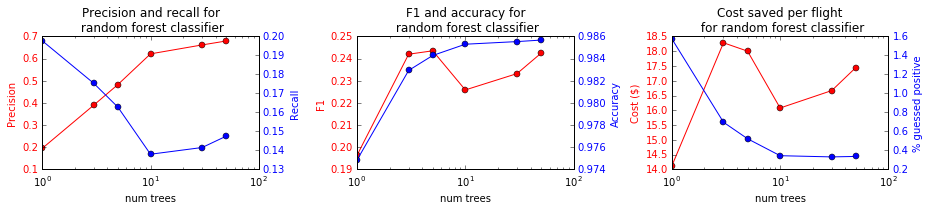

In [19]:
fig = plt.figure(figsize=(13,3))
ax1 = fig.add_subplot(131)
ax1.plot(tree_list,precision,'-or')
ax1.set_xlabel('num trees')
ax1.set_xscale('log')
ax1.set_ylabel('Precision', color='r')
ax1.set_title('Precision and recall for\n random forest classifier')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(tree_list, recall, '-ob')
ax2.set_ylabel('Recall', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
ax3 = fig.add_subplot(132)
ax3.plot(tree_list,F1,'-or')
ax3.set_xlabel('num trees')
ax3.set_xscale('log')
ax3.set_ylabel('F1', color='r')
ax3.set_title('F1 and accuracy for\n random forest classifier')
for tl in ax3.get_yticklabels():
    tl.set_color('r')

ax4 = ax3.twinx()
ax4.plot(tree_list, accuracy, '-ob')
ax4.set_ylabel('Accuracy', color='b')
ax4.yaxis.set_major_formatter(y_formatter)
for tl in ax4.get_yticklabels():
    tl.set_color('b')
    
ax5 = fig.add_subplot(133)
ax5.plot(tree_list,saved_cost,'-or')
ax5.set_xlabel('num trees')
ax5.set_xscale('log')
ax5.set_ylabel('Cost ($)',color='r')
ax5.set_title('Cost saved per flight\n for random forest classifier')
for tl in ax5.get_yticklabels():
    tl.set_color('r')

num_pos = [(conf_matrix[trees][0][1]+conf_matrix[trees][1][1])*100/sum(sum(conf_matrix[trees]))
           for trees in tree_list]
ax6 = ax5.twinx()
ax6.plot(tree_list, num_pos, '-ob')
ax6.set_ylabel('% guessed positive', color='b')
ax6.yaxis.set_major_formatter(y_formatter)
for tl in ax6.get_yticklabels():
    tl.set_color('b')

fig.tight_layout()
fig.savefig('../reports/figures/classification/rf_reg_trees', bbox_inches='tight')

With fewer trees we are overfitting the data, so we generate more positives meaning our precision is low but our recall is high.  
Up to 10 trees the number of positives predicted decreases, so the precision increases sharply and our recall drops as we decrease the variance in the model. This leads to a decrease the cost saved per flight.  
However beyond 10 trees the number of positive predictions is more or less constant, and so by adding more trees we improve the performance of the model and hence the cost.

So in fact fewer (3) trees performs better.

In [49]:
alg = RandomForestClassifier(n_estimators=3)
#Features from original data
predictors = list(model_data.columns[2:64])+list(model_data.columns[66:81])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.4f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0     1
0  570671  2440
1    7305  1492
precision = 0.38, recall = 0.17, F1 = 0.23, accuracy = 0.9833, saved cost per flight = $17.05


Now let's apply this model with the new sets of features, starting with the urban data.

In [53]:
alg = RandomForestClassifier(n_estimators=3)
#Features from original data
predictors = list(model_data.columns[2:81])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.3f}, recall = {1:.3f}, F1 = {2:.3f}, ' 
       'accuracy = {3:.3f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0     1
0  570721  2390
1    7284  1513
precision = 0.388, recall = 0.172, F1 = 0.238, accuracy = 0.983, saved cost per flight = $17.41


And now the weather data

In [54]:
alg = RandomForestClassifier(n_estimators=3)
#Features from original data
predictors = list(model_data.columns[2:94])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.3f}, recall = {1:.3f}, F1 = {2:.3f}, ' 
       'accuracy = {3:.3f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0     1
0  570478  2633
1    7212  1585
precision = 0.376, recall = 0.180, F1 = 0.244, accuracy = 0.983, saved cost per flight = $18.06


And the aircraft data

In [55]:
alg = RandomForestClassifier(n_estimators=3)
#Features from original data
predictors = list(model_data.columns[2:])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.3f}, recall = {1:.3f}, F1 = {2:.3f}, ' 
       'accuracy = {3:.3f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0     1
0  570785  2326
1    7278  1519
precision = 0.395, recall = 0.173, F1 = 0.240, accuracy = 0.983, saved cost per flight = $17.59


In [41]:
#Try these trees
tree_list = [1,3,5,10,30,50]

predictors = list(model_data.columns[2:])

conf_matrix = {}
coef = {}
precision = []; recall = []; F1 = []; accuracy = []; saved_cost = []
for trees in tree_list:
    alg = RandomForestClassifier(n_estimators=trees)

    #Split the data into 10 subsets
    kf = KFold(shuffled_data.shape[0], n_folds = 10, random_state = 1)
    predictions = []

    #Train and predict
    for train, test in kf:
        X_train = (shuffled_data[predictors].iloc[train,:])
        scaler = StandardScaler().fit(X_train)
        y_train = shuffled_data['Cancelled'].iloc[train]
        %time alg.fit(scaler.transform(X_train), y_train)
        X_test = (shuffled_data[predictors].iloc[test,:])
        y_test = shuffled_data['Cancelled'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)
        gc.collect()

    predictions = np.concatenate(predictions,axis = 0)
    conf_matrix[trees] = confusion_matrix(shuffled_data['Cancelled'].values, predictions)
    print('Num trees = {0}\nConfusion matrix'.format(trees))
    print(pd.DataFrame(conf_matrix[trees]))
    
    scores = precision_recall_fscore_support(shuffled_data['Cancelled'].values, predictions)
    precision.append(scores[0][1]); recall.append(scores[1][1]); F1.append(scores[2][1])
    accuracy.append(accuracy_score(shuffled_data['Cancelled'].values, predictions))
    saved_cost.append(cost_saved(conf_matrix[trees])/len(predictions))
    
    print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(precision[-1],recall[-1],F1[-1],
                                                                   accuracy[-1],saved_cost[-1]))

Wall time: 11 s
Wall time: 10.8 s
Wall time: 11 s
Wall time: 10.7 s
Wall time: 10.7 s
Wall time: 10.2 s
Wall time: 10.5 s
Wall time: 10.3 s
Wall time: 10.3 s
Wall time: 10.7 s
Num trees = 1
Confusion matrix
        0     1
0  565223  7643
1    7068  1974
precision = 0.21, recall = 0.22, F1 = 0.21, accuracy = 0.97, saved cost per flight = $16.30
Wall time: 15 s
Wall time: 15.4 s
Wall time: 15.5 s
Wall time: 15.4 s
Wall time: 15.6 s
Wall time: 15.2 s
Wall time: 15.2 s
Wall time: 15 s
Wall time: 15.1 s
Wall time: 15.9 s
Num trees = 3
Confusion matrix
        0     1
0  570491  2375
1    7383  1659
precision = 0.41, recall = 0.18, F1 = 0.25, accuracy = 0.98, saved cost per flight = $19.44
Wall time: 21.9 s
Wall time: 21.9 s
Wall time: 21.7 s
Wall time: 22.1 s
Wall time: 22.1 s
Wall time: 22.4 s
Wall time: 23.7 s
Wall time: 22.5 s
Wall time: 24.7 s
Wall time: 27.2 s
Num trees = 5
Confusion matrix
        0     1
0  571256  1610
1    7451  1591
precision = 0.50, recall = 0.18, F1 = 0.26, acc

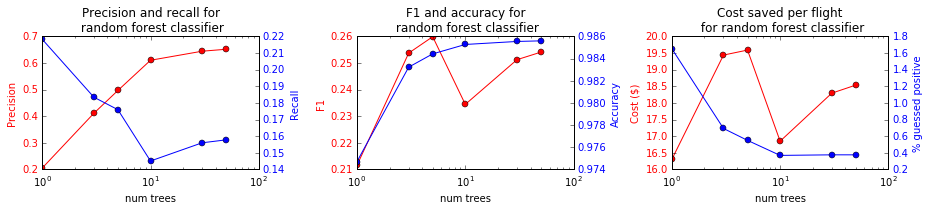

In [42]:
fig = plt.figure(figsize=(13,3))
ax1 = fig.add_subplot(131)
ax1.plot(tree_list,precision,'-or')
ax1.set_xlabel('num trees')
ax1.set_xscale('log')
ax1.set_ylabel('Precision', color='r')
ax1.set_title('Precision and recall for\n random forest classifier')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(tree_list, recall, '-ob')
ax2.set_ylabel('Recall', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
ax3 = fig.add_subplot(132)
ax3.plot(tree_list,F1,'-or')
ax3.set_xlabel('num trees')
ax3.set_xscale('log')
ax3.set_ylabel('F1', color='r')
ax3.set_title('F1 and accuracy for\n random forest classifier')
for tl in ax3.get_yticklabels():
    tl.set_color('r')

ax4 = ax3.twinx()
ax4.plot(tree_list, accuracy, '-ob')
ax4.set_ylabel('Accuracy', color='b')
ax4.yaxis.set_major_formatter(y_formatter)
for tl in ax4.get_yticklabels():
    tl.set_color('b')
    
ax5 = fig.add_subplot(133)
ax5.plot(tree_list,saved_cost,'-or')
ax5.set_xlabel('num trees')
ax5.set_xscale('log')
ax5.set_ylabel('Cost ($)',color='r')
ax5.set_title('Cost saved per flight\n for random forest classifier')
for tl in ax5.get_yticklabels():
    tl.set_color('r')

num_pos = [(conf_matrix[trees][0][1]+conf_matrix[trees][1][1])*100/sum(sum(conf_matrix[trees]))
           for trees in tree_list]
ax6 = ax5.twinx()
ax6.plot(tree_list, num_pos, '-ob')
ax6.set_ylabel('% guessed positive', color='b')
ax6.yaxis.set_major_formatter(y_formatter)
for tl in ax6.get_yticklabels():
    tl.set_color('b')

fig.tight_layout()
fig.savefig('../reports/figures/classification/rf2_reg_trees', bbox_inches='tight')

In [45]:
#Try these leaves
leaf_list = [1,2,3,5,7,10]

predictors = list(model_data.columns[2:])

conf_matrix = {}
coef = {}
precision = []; recall = []; F1 = []; accuracy = []; saved_cost = []
for leaf in leaf_list:
    alg = RandomForestClassifier(min_samples_leaf=leaf, n_estimators=5)

    #Split the data into 10 subsets
    kf = KFold(shuffled_data.shape[0], n_folds = 10, random_state = 1)
    predictions = []

    #Train and predict
    for train, test in kf:
        X_train = (shuffled_data[predictors].iloc[train,:])
        scaler = StandardScaler().fit(X_train)
        y_train = shuffled_data['Cancelled'].iloc[train]
        alg.fit(scaler.transform(X_train), y_train)
        X_test = (shuffled_data[predictors].iloc[test,:])
        y_test = shuffled_data['Cancelled'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)
        gc.collect()

    predictions = np.concatenate(predictions,axis = 0)
    conf_matrix[leaf] = confusion_matrix(shuffled_data['Cancelled'].values, predictions)
    print('Min leaf size = {0}\nConfusion matrix'.format(leaf))
    print(pd.DataFrame(conf_matrix[leaf]))
    
    scores = precision_recall_fscore_support(shuffled_data['Cancelled'].values, predictions)
    precision.append(scores[0][1]); recall.append(scores[1][1]); F1.append(scores[2][1])
    accuracy.append(accuracy_score(shuffled_data['Cancelled'].values, predictions))
    saved_cost.append(cost_saved(conf_matrix[leaf])/len(predictions))
    
    print(('precision = {0:.2f}, recall = {1:.2f}, F1 = {2:.2f}, ' 
       'accuracy = {3:.2f}, saved cost per flight = ${4:.2f}').format(precision[-1],recall[-1],F1[-1],
                                                                   accuracy[-1],saved_cost[-1]))

Min leaf size = 1
Confusion matrix
        0     1
0  571266  1600
1    7446  1596
precision = 0.50, recall = 0.18, F1 = 0.26, accuracy = 0.98, saved cost per flight = $19.67
Min leaf size = 2
Confusion matrix
        0     1
0  572271   595
1    7816  1226
precision = 0.67, recall = 0.14, F1 = 0.23, accuracy = 0.99, saved cost per flight = $16.01
Min leaf size = 3
Confusion matrix
        0     1
0  572476   390
1    7964  1078
precision = 0.73, recall = 0.12, F1 = 0.21, accuracy = 0.99, saved cost per flight = $14.27
Min leaf size = 5
Confusion matrix
        0    1
0  572587  279
1    8140  902
precision = 0.76, recall = 0.10, F1 = 0.18, accuracy = 0.99, saved cost per flight = $12.01
Min leaf size = 7
Confusion matrix
        0    1
0  572650  216
1    8237  805
precision = 0.79, recall = 0.09, F1 = 0.16, accuracy = 0.99, saved cost per flight = $10.76
Min leaf size = 10
Confusion matrix
        0    1
0  572681  185
1    8299  743
precision = 0.80, recall = 0.08, F1 = 0.15, accura

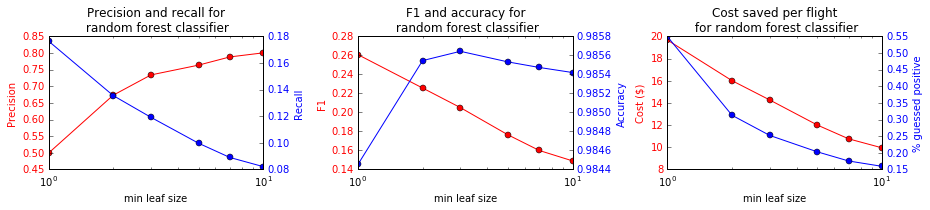

In [46]:
fig = plt.figure(figsize=(13,3))
ax1 = fig.add_subplot(131)
ax1.plot(leaf_list,precision,'-or')
ax1.set_xlabel('min leaf size')
ax1.set_xscale('log')
ax1.set_ylabel('Precision', color='r')
ax1.set_title('Precision and recall for\n random forest classifier')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(leaf_list, recall, '-ob')
ax2.set_ylabel('Recall', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
ax3 = fig.add_subplot(132)
ax3.plot(leaf_list,F1,'-or')
ax3.set_xlabel('min leaf size')
ax3.set_xscale('log')
ax3.set_ylabel('F1', color='r')
ax3.set_title('F1 and accuracy for\n random forest classifier')
for tl in ax3.get_yticklabels():
    tl.set_color('r')

ax4 = ax3.twinx()
ax4.plot(leaf_list, accuracy, '-ob')
ax4.set_ylabel('Accuracy', color='b')
ax4.yaxis.set_major_formatter(y_formatter)
for tl in ax4.get_yticklabels():
    tl.set_color('b')
    
ax5 = fig.add_subplot(133)
ax5.plot(leaf_list,saved_cost,'-or')
ax5.set_xlabel('min leaf size')
ax5.set_xscale('log')
ax5.set_ylabel('Cost ($)',color='r')
ax5.set_title('Cost saved per flight\n for random forest classifier')
for tl in ax5.get_yticklabels():
    tl.set_color('r')

num_pos = [(conf_matrix[leaf][0][1]+conf_matrix[leaf][1][1])*100/sum(sum(conf_matrix[leaf]))
           for leaf in leaf_list]
ax6 = ax5.twinx()
ax6.plot(leaf_list, num_pos, '-ob')
ax6.set_ylabel('% guessed positive', color='b')
ax6.yaxis.set_major_formatter(y_formatter)
for tl in ax6.get_yticklabels():
    tl.set_color('b')

fig.tight_layout()
fig.savefig('../reports/figures/classification/rf2_reg_leaves', bbox_inches='tight')

So the optimum number of trees with all features added is now 5, with no (i.e. 1) minimum leaf size still performing best.

Let's see how this performs for all features:

In [56]:
alg = RandomForestClassifier(n_estimators=5)
#Features from original data
predictors = list(model_data.columns[2:])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.3f}, recall = {1:.3f}, F1 = {2:.3f}, ' 
       'accuracy = {3:.3f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0     1
0  571610  1501
1    7354  1443
precision = 0.490, recall = 0.164, F1 = 0.246, accuracy = 0.985, saved cost per flight = $17.71


In [57]:
alg = RandomForestClassifier(n_estimators=5)
#Features from original data
predictors = list(model_data.columns[2:94])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.3f}, recall = {1:.3f}, F1 = {2:.3f}, ' 
       'accuracy = {3:.3f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0     1
0  571243  1868
1    7263  1534
precision = 0.451, recall = 0.174, F1 = 0.251, accuracy = 0.984, saved cost per flight = $18.44


In [58]:
alg = RandomForestClassifier(n_estimators=50,min_samples_leaf=3)
#Features from original data
predictors = list(model_data.columns[2:])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    %time alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.3f}, recall = {1:.3f}, F1 = {2:.3f}, ' 
       'accuracy = {3:.3f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Wall time: 2min 17s
Wall time: 2min 29s
Wall time: 2min 23s
Wall time: 2min 36s
Wall time: 2min 35s
Wall time: 2min 38s
Wall time: 2min 13s
Wall time: 2min 17s
Wall time: 2min 12s
Wall time: 2min 25s
Confusion matrix
        0    1
0  572874  237
1    7890  907
precision = 0.793, recall = 0.103, F1 = 0.182, accuracy = 0.986, saved cost per flight = $12.13


Let's finally see how we perform without any 'future' knowledge.

In [63]:
alg = RandomForestClassifier(n_estimators=5)
#Features from original data
predictors = list(model_data.columns[2:8])+list(model_data.columns[9:81])+list(model_data.columns[94:])

#Split the data into 10 subsets
kf = KFold(cv_data.shape[0], n_folds = 10, random_state = 1)
predictions = []

#Train and predict
for train, test in kf:
    X_train = (cv_data[predictors].iloc[train,:])
    scaler = StandardScaler().fit(X_train)
    y_train = cv_data['Cancelled'].iloc[train]
    alg.fit(scaler.transform(X_train), y_train)
    X_test = (cv_data[predictors].iloc[test,:])
    y_test = cv_data['Cancelled'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)
    gc.collect()

predictions = np.concatenate(predictions,axis = 0)
conf_matrix = confusion_matrix(cv_data['Cancelled'].values, predictions)
print('Confusion matrix')
print(pd.DataFrame(conf_matrix))
scores = precision_recall_fscore_support(cv_data['Cancelled'].values, predictions)
print(('precision = {0:.3f}, recall = {1:.3f}, F1 = {2:.3f}, ' 
       'accuracy = {3:.3f}, saved cost per flight = ${4:.2f}').format(scores[0][1],scores[1][1],scores[2][1],
                                                        accuracy_score(cv_data['Cancelled'].values, predictions),
                                                        cost_saved(conf_matrix)/len(predictions)))

Confusion matrix
        0     1
0  571817  1294
1    7525  1272
precision = 0.496, recall = 0.145, F1 = 0.224, accuracy = 0.985, saved cost per flight = $15.65
